## Задача 3. Python

## Условие

Задача №3 Является продолжением задачи №1 и требует следующее:
- Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
- Реализовать функцию, которая будет строить графики по получаемым метрикам.

### Загружаем необходимые для работы модули и библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind

import requests
from urllib.parse import urlencode


### С целью прямой загрузки датасетов с disc.yandex создаём ссылки

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

# Создаём словарь для хранения ссылок
links = {
    'groups': 'https://disk.yandex.ru/d/58Us0DWOzuWAjg',
    'active_studs': 'https://disk.yandex.ru/d/prbgU-rZpiXVYg',
    'checks': 'https://disk.yandex.ru/d/84hTmELphW2sqQ'
}

# Создаём функцию для получения данных по ссылке
def get_dataset_url(public_key):
    url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(url)
    return response.json()['href']


# Используем функцию для получения всех данных
datasets = {name: get_dataset_url(link) for name, link in links.items()}

groups_dataset = datasets['groups']
active_studs_dataset = datasets['active_studs']
checks_dataset = datasets['checks']

**Создание функции для вывода метрик**  
Создаём основную функцию с целью реализации цикла загрузки датасетов и формирования таблиц с дальнейшей выгрузкой итоговых показателей метрик

In [3]:
# Загрузка 3-х основных датасетов из CSV файлов с переименованием колонок
def build():
    df_groups = pd.read_csv(groups_dataset, sep=';', header=0, names=['user_id', 'group'])
    df_active_user = pd.read_csv(active_studs_dataset, header=0, names=['user_id'])
    df_checks = pd.read_csv(checks_dataset, sep=';', header=0, names=['user_id', 'pay'])

    # С помощью конструкции "try - except" для обработки исключений
    # осуществление попытки добавить дополнительные данные о группах, если они существуют
    # с соответствующим выводе о присутствии или отсутствии датасета
    
    try:
        df_add = pd.read_csv(groups_add_dataset, names=['user_id', 'group'], header=0)
        df_groups = pd.concat([df_groups, df_add])
        print('Дополнительные пользователи присутствуют')
    except NameError:
        print('Дополнительных пользователей нет')
    
     # Объединяем активных пользователей с группами
    df_active_groups = df_active_user.merge(df_groups, on='user_id', how='left').dropna()
    
    # Объединяем данные о платежах с группами
    df_checks_groups = df_checks.merge(df_groups, on='user_id', how='left').dropna()
    
    # Объединяем все данные
    total_df = pd.merge(df_active_groups, df_checks_groups, on=['user_id', 'group'], how='outer').fillna(0)
    total_df['pay_mark'] = total_df['pay'].apply(lambda x: 'no' if x == 0 else 'yes')
    
    # Создаём сводную таблицу по группам и наличию платежей
    table = total_df.groupby(['group', 'pay_mark']).size().unstack(fill_value=0)
    
    # Расчитываем конверсию в оплату
    CR = (table['yes'] / table.sum(axis=1) * 100).round(2)
    
    # Применяем статистический тест хи-квадрат
    stat, p_CR, dof, expected = chi2_contingency(table)
    
    # Расчитываем ARPPU (Средний доход на платящего пользователя)
    ARPPU = total_df.query('pay > 0').groupby('group')['pay'].mean().round(2)
    
    # t-тест для сравнения ARPPU между группами
    p_ARPPU = ttest_ind(total_df.query('group == "A" & pay > 0')['pay'],
                        total_df.query('group == "B" & pay > 0')['pay'])[1]

    
    return CR, p_CR, ARPPU, p_ARPPU

In [4]:
# Применяем функцию и выводим результат
CR, p_CR, ARPPU, p_ARPPU = build()

print(f"\nМетрика CR:\n{CR}\n\n p-value CR: {p_CR}\n\nМетрика ARPPU:\n{ARPPU}\n\n p-value ARPPU: {p_ARPPU}")

ВНИМАНИЕ! Дополнительные пользователи не загружены

Метрика CR:
group
A    6.84
B    6.26
dtype: float64

 p-value CR: 0.4308630604023529

Метрика ARPPU:
group
A     860.71
B    1107.00
Name: pay, dtype: float64

 p-value ARPPU: 0.002699993302662584


В случае обновления данных и предоставления ссылки на них, назначим переменную для обновленной информации о дополнительных пользователях.

In [5]:
# Добавляем ссылку на дополнительные группы
groups_add = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'

# Создаём функцию для получения ссылки на скачивание данных
def get_download_url(public_key):
    url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(url)
    return response.json()['href']

# Получаем ссылку на дополнительный датасет
groups_add_dataset = get_download_url(groups_add)

Применяем функцию с учетом дополнительных данных

In [6]:
CR_n, p_CR_n, ARPPU_n, p_ARPPU_n = build()

print(f"\nМетрика CR:\n{CR_n}\n\n p-value CR: {p_CR_n}\n\nМетрика ARPPU:\n{ARPPU_n}\n\n p-value ARPPU: {p_ARPPU_n}")

Результаты с учетом дополнительных пользователей

Метрика CR:
group
A    6.83
B    6.27
dtype: float64

 p-value CR: 0.4464432666411111

Метрика ARPPU:
group
A     860.71
B    1108.82
Name: pay, dtype: float64

 p-value ARPPU: 0.0025070167572044644


Формируем функцию для вывода графиков по получаемым метрикам

In [7]:
# Создаём функцию, принимающую 2 метрики "CR" и "ARPPU" из предыдущей функции.
def plot(CR, ARPPU):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # График для CR
    sns.barplot(data=CR.reset_index(), x='group', y=0, ax=axes[0])
    axes[0].set_xlabel('Экспериментальная группа', fontsize=15)
    axes[0].set_ylabel('CR (%)', fontsize=15)
    axes[0].set_ylim(0, 10)
    axes[0].set_title('Метрика CR (%)', fontsize=20)

    # График для ARPPU
    sns.barplot(data=ARPPU.reset_index(), x='group', y='pay', ax=axes[1])
    axes[1].set_xlabel('Экспериментальная группа', fontsize=15)
    axes[1].set_ylabel('ARPPU (у.е.)', fontsize=15)
    axes[1].set_title('Метрика ARPPU (у.е.)', fontsize=20)

Визуализируем график **без учёта** дополнительных данных с помощью диаграммы – барплот

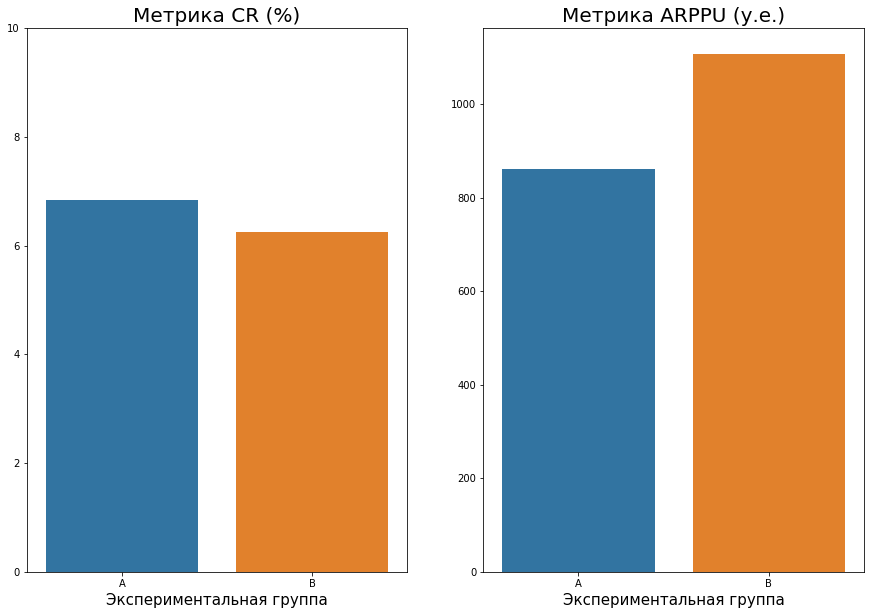

In [8]:
plot(CR, ARPPU)

Визуализируем график **с учётом** дополнительных данных с помощью диаграммы – барплот
(Вывод будет одинаковым, так так дополнительных групп нет)

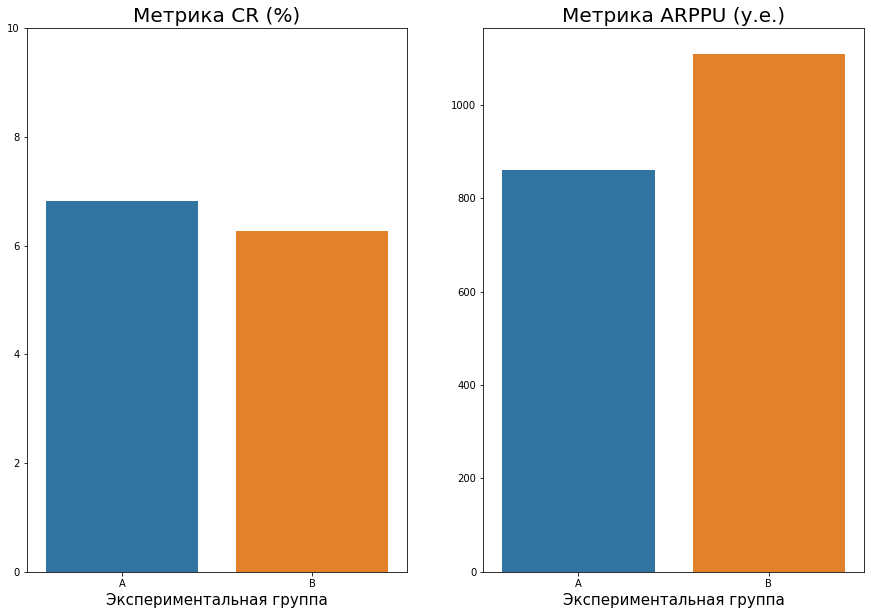

In [9]:
plot(CR_n, ARPPU_n)

## Вывод

Была разработана функция, которая выполняет следующие шаги:

Загрузка данных: Функция автоматически загружает основной и дополнительный файлы данных, используя динамическое получение ссылки на скачивание. В случае наличия файла groups_add.csv данные объединяются с основным датасетом.

Обработка данных: С учетом возможных различий в заголовках, данные из groups_add.csv корректно интегрируются в основной датасет. Это позволяет расширить анализ, включив дополнительные параметры.

Пересчет метрик: После объединения данных пересчитываются ключевые метрики, такие как CR (Conversion Rate) и ARPPU (Average Revenue Per Paying User), для каждой экспериментальной группы.

Визуализация результатов: Построены графики для визуализации пересчитанных метрик, что облегчает интерпретацию результатов эксперимента.

Таким образом, функция обеспечивает автоматическую обработку и анализ данных с учетом дополнительных параметров, что позволяет гибко адаптироваться к изменяющимся условиям эксперимента.